# Imports

In [1]:
from mx_mg import builders, data
import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True
import numpy as np
import random
import rdkit_contrib

# Unconditional models: MolMP and MolRNN

In [ ]:
# loading models
mol_mp = builders.Vanilla_Builder('ckpt/molmp_0/', gpu_id=0)
mol_rnn = builders.Vanilla_RNN_Builder('ckpt/molrnn_0/', gpu_id=0)

# sampling
samples_mol_mp = [m for m in mol_mp.sample(100) if m is not None]
samples_mol_rnn = [m for m in mol_rnn.sample(100) if m is not None]

### visualization

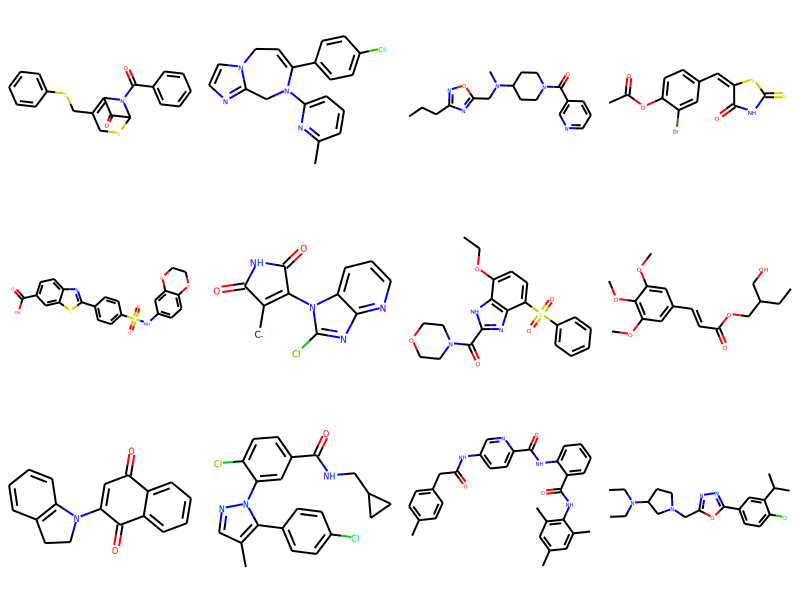

In [8]:
random.shuffle(samples_mol_mp)
Draw.MolsToGridImage(samples_mol_mp[:12], molsPerRow=4)

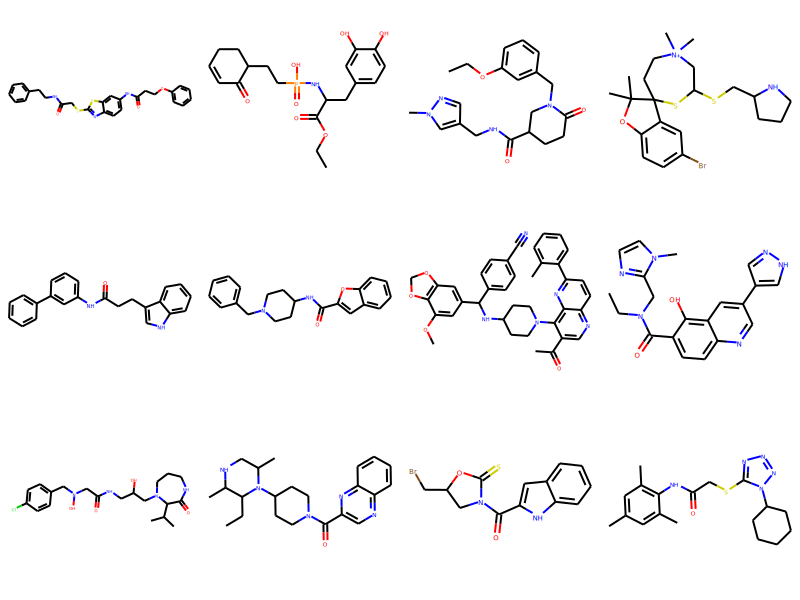

In [9]:
random.shuffle(samples_mol_rnn)
Draw.MolsToGridImage(samples_mol_rnn[:12], molsPerRow=4)

# Scaffold based generation

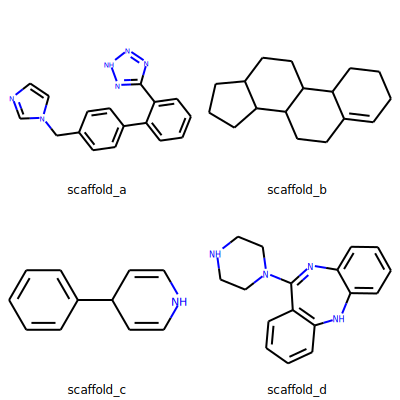

In [2]:
# defining scaffolds
scaffolds = ['N1(CC2=CC=C(C3=CC=CC=C3C4=NNN=N4)C=C2)C=NC=C1', # -> losartan
             'C12=CCCCC1C3C(C(CCC4)C4CC3)CC2', # -> hydrocortisone
             'C1(C2C=CNC=C2)=CC=CC=C1', # -> nifendipine
             'C12=CC=CC=C1N=C(N3CCNCC3)C4=C(C=CC=C4)N2'] # -> clozapine
names = ['scaffold_{}'.format(ids) for ids in ['a', 'b', 'c', 'd']]
scaffolds_mol = [Chem.MolFromSmiles(s) for s in scaffolds]
Draw.MolsToGridImage(scaffolds_mol, molsPerRow=2, legends=names)

In [3]:
# helper for building fingperprints
fp_builder = data.conditionals.ScaffoldFP('datasets/scaffolds.smi')
# build fingerprint for the four scaffolds
c = np.zeros([4, len(fp_builder.scaffolds)], dtype=np.float32)
for i, s in enumerate(scaffolds):
    on_bits = fp_builder.get_on_bits(s)
    c[i, on_bits] = 1.0

In [ ]:
# load model
mdl_scaffold = builders.CVanilla_RNN_Builder('ckpt/scaffold_0/', gpu_id=0)

In [ ]:
# sample results
scaffold_outputs = []
for i in range(4):
    samples_scaffold_i = [m for m in mdl_scaffold.sample(100, c=c[i, :], output_type='mol') 
                          if m is not None]
    samples_scaffold_i_match = []
    for m in samples_scaffold_i:
        c_i = fp_builder(m)[1].astype(np.float)
        if np.all(c_i==c[i, :]):
            samples_scaffold_i_match.append(m)
    _smiles_list = [Chem.MolToSmiles(m) for m in samples_scaffold_i_match]
    _smiles_list = list(set(_smiles_list))
    samples_scaffold_i_match = [Chem.MolFromSmiles(s) for s in _smiles_list]
    random.shuffle(samples_scaffold_i_match)
    scaffold_outputs.append(samples_scaffold_i_match)

### scaffold a

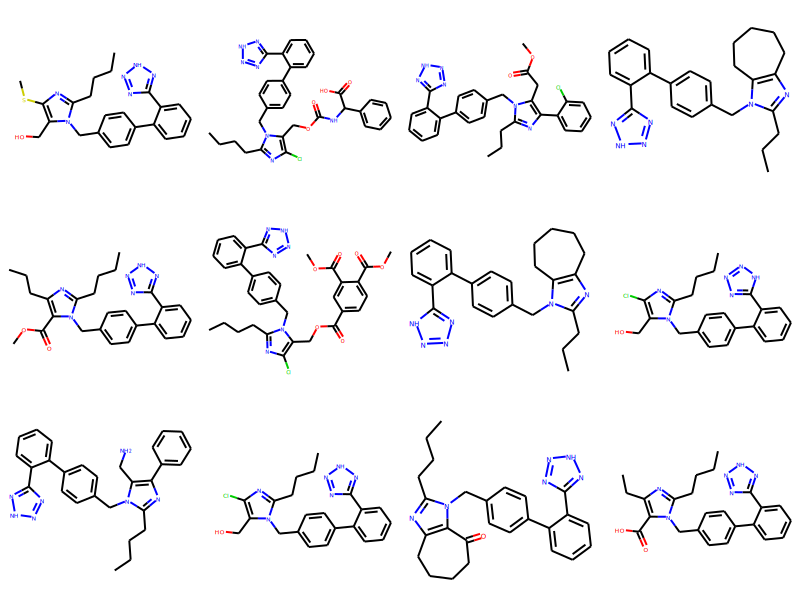

In [6]:
random.shuffle(scaffold_outputs[0])
Draw.MolsToGridImage(scaffold_outputs[0][:12], molsPerRow=4)

### scaffold b

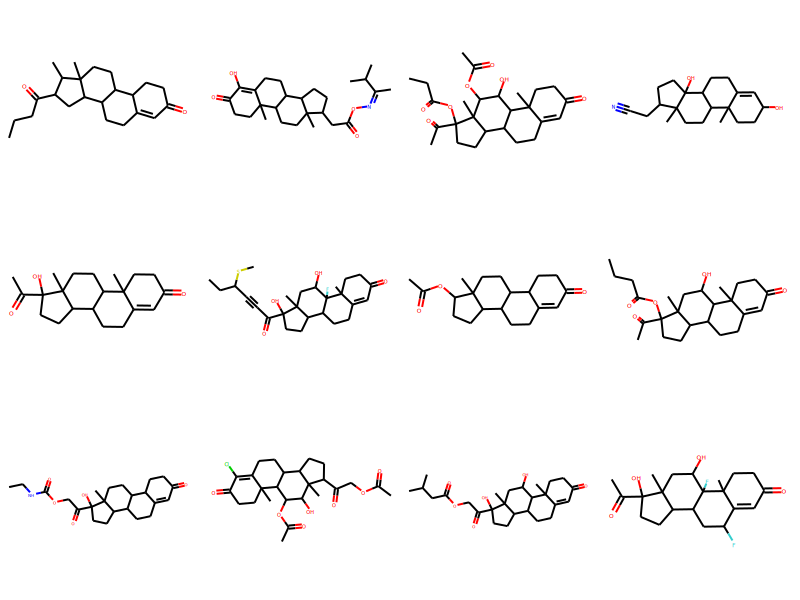

In [7]:
random.shuffle(scaffold_outputs[1])
Draw.MolsToGridImage(scaffold_outputs[1][:12], molsPerRow=4)

### scaffold c

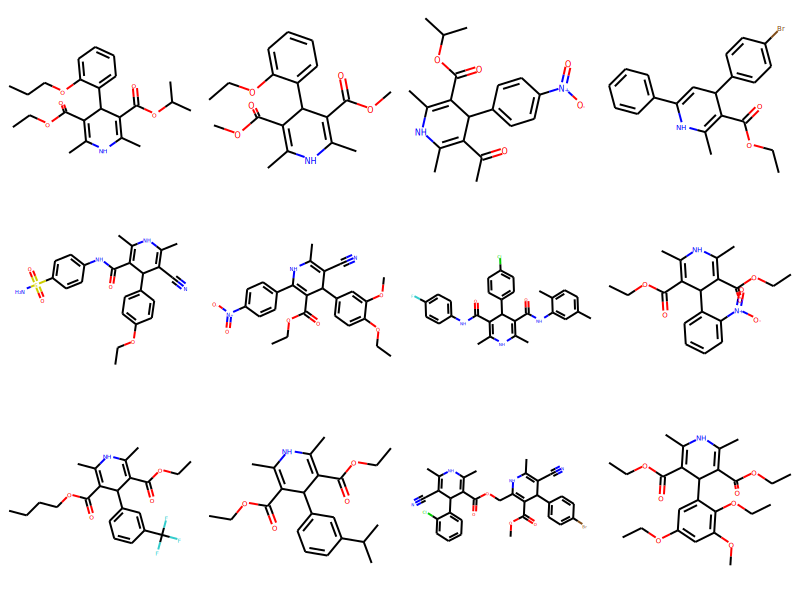

In [8]:
random.shuffle(scaffold_outputs[2])
Draw.MolsToGridImage(scaffold_outputs[2][:12], molsPerRow=4)

### scaffold d

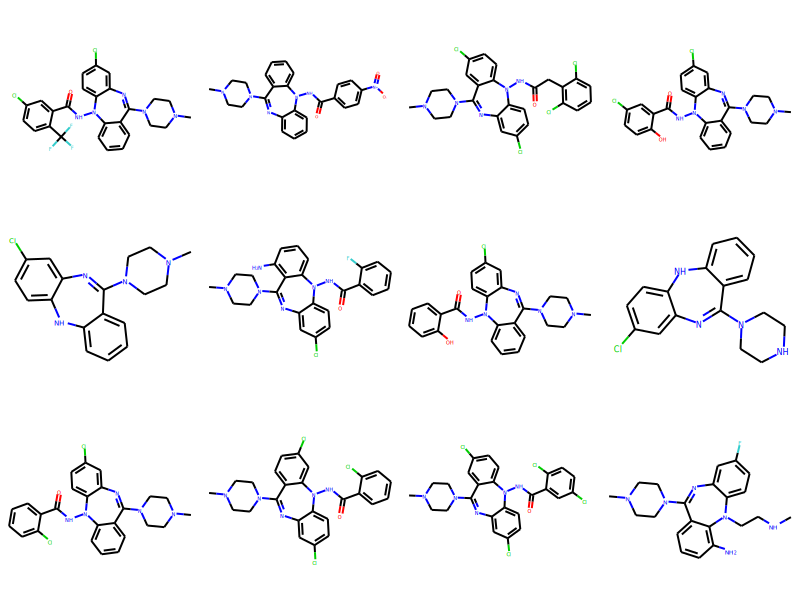

In [9]:
random.shuffle(scaffold_outputs[3])
Draw.MolsToGridImage(scaffold_outputs[3][:12], molsPerRow=4)

## Property based generation

In [ ]:
# conditional codes:
c = [[0.84, 1.9], 
     [0.27, 2.5], 
     [0.84, 3.8], 
     [0.27, 4.8]]
c = np.array(c, dtype=np.float32)
# load model
mdl_prop = builders.CVanilla_RNN_Builder('ckpt/prop_0/', gpu_id=0)
# sample results
prop_outputs = []
for i in range(4):
    samples_prop_i = [m for m in mdl_prop.sample(100, c=c[i, :], output_type='mol') 
                      if m is not None]
    _smiles_list = [Chem.MolToSmiles(m) for m in samples_prop_i]
    _smiles_list = list(set(_smiles_list))
    samples_prop_i = [Chem.MolFromSmiles(s) for s in _smiles_list]
    random.shuffle(samples_prop_i)
    prop_outputs.append(samples_prop_i)

### ${\bf c}_1=(0.84, 1.9)$

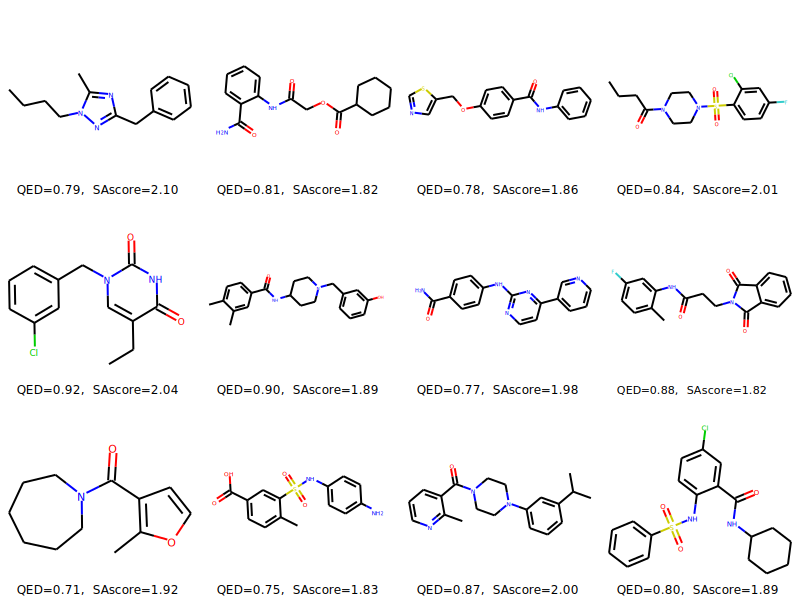

In [5]:
random.shuffle(prop_outputs[0])
legends = ['QED={:.2f},\n SAscore={:.2f}'.format(rdkit_contrib.qed.qed(m), rdkit_contrib.sascorer.calculateScore(m))
           for m in prop_outputs[0][:12]]
Draw.MolsToGridImage(prop_outputs[0][:12], molsPerRow=4, legends=legends)

### ${\bf c}_2=(0.27, 2.5)$

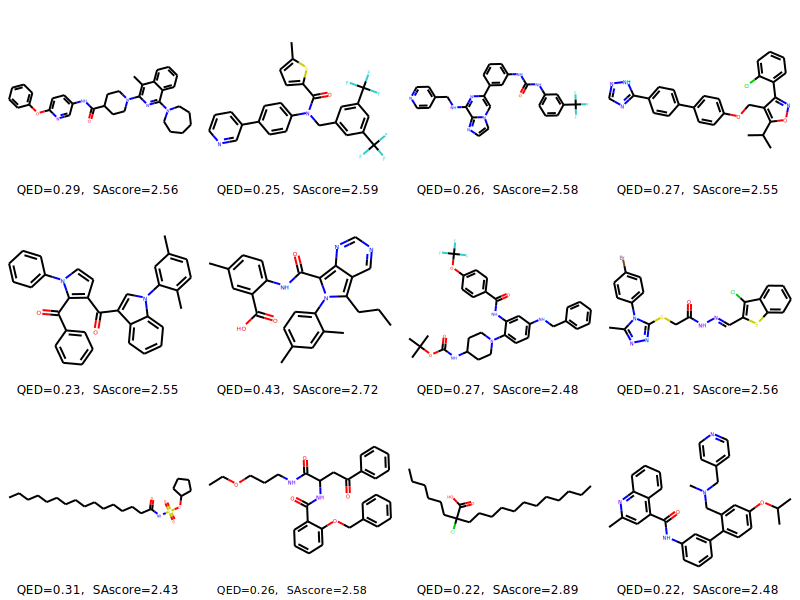

In [6]:
random.shuffle(prop_outputs[1])
legends = ['QED={:.2f},\n SAscore={:.2f}'.format(rdkit_contrib.qed.qed(m), rdkit_contrib.sascorer.calculateScore(m))
           for m in prop_outputs[1][:12]]
Draw.MolsToGridImage(prop_outputs[1][:12], molsPerRow=4, legends=legends)

### ${\bf c}_3=(0.84, 3.8)$

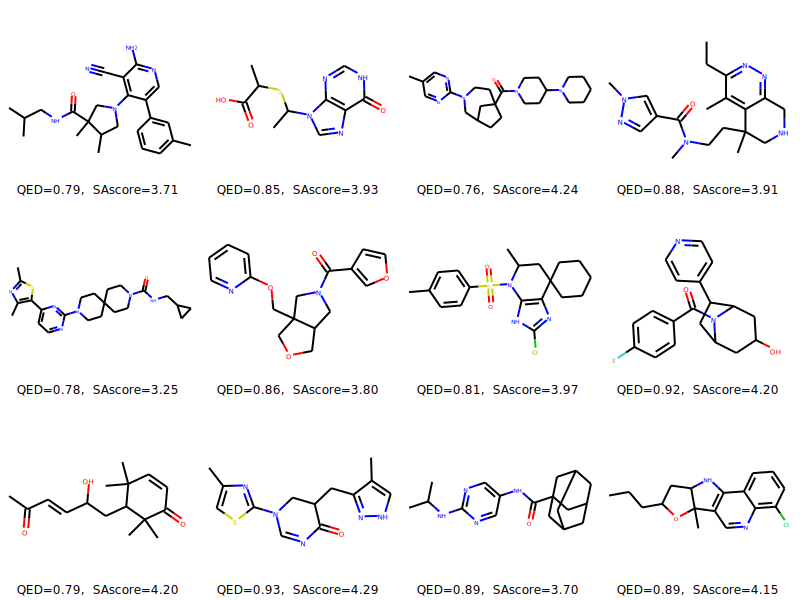

In [8]:
random.shuffle(prop_outputs[2])
legends = ['QED={:.2f},\n SAscore={:.2f}'.format(rdkit_contrib.qed.qed(m), rdkit_contrib.sascorer.calculateScore(m))
           for m in prop_outputs[2][:12]]
Draw.MolsToGridImage(prop_outputs[2][:12], molsPerRow=4, legends=legends)

### ${\bf c}_4=(0.27, 4.8)$

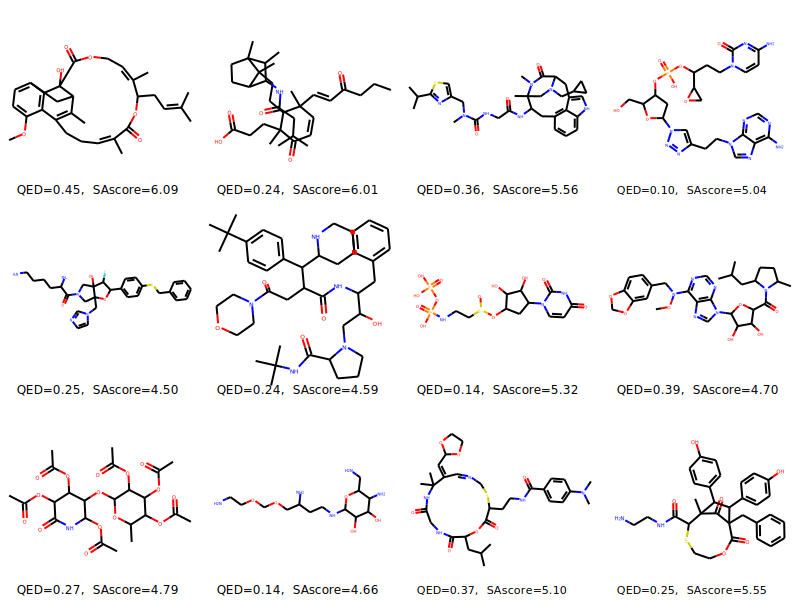

In [10]:
random.shuffle(prop_outputs[3])
legends = ['QED={:.2f},\n SAscore={:.2f}'.format(rdkit_contrib.qed.qed(m), rdkit_contrib.sascorer.calculateScore(m))
           for m in prop_outputs[3][:12]]
Draw.MolsToGridImage(prop_outputs[3][:12], molsPerRow=4, legends=legends)

## GSK-3$\beta$ and JNK3

In [ ]:
# conditional codes:
c = [[1, 1], # GSK-3b(+) & JNK3(+)
     [1, 0], # GSK-3b(+) & JNK3(-)
     [0, 1]] # GSK-3b(-) & JNK3(+)
c = np.array(c, dtype=np.float32)
# load model
mdl_kinase = builders.CVanilla_RNN_Builder('ckpt/kinase_0/', gpu_id=0)
# sample results
kinase_outputs = []
for i in range(3):
    samples_kinase_i = [m for m in mdl_kinase.sample(100, c=c[i, :], output_type='mol') 
                       if m is not None]
    _smiles_list = [Chem.MolToSmiles(m) for m in samples_kinase_i]
    _smiles_list = list(set(_smiles_list))
    samples_kinase_i = [Chem.MolFromSmiles(s) for s in _smiles_list]
    random.shuffle(samples_kinase_i)
    kinase_outputs.append(samples_kinase_i)

### GSK-3b(+) & JNK3(+)

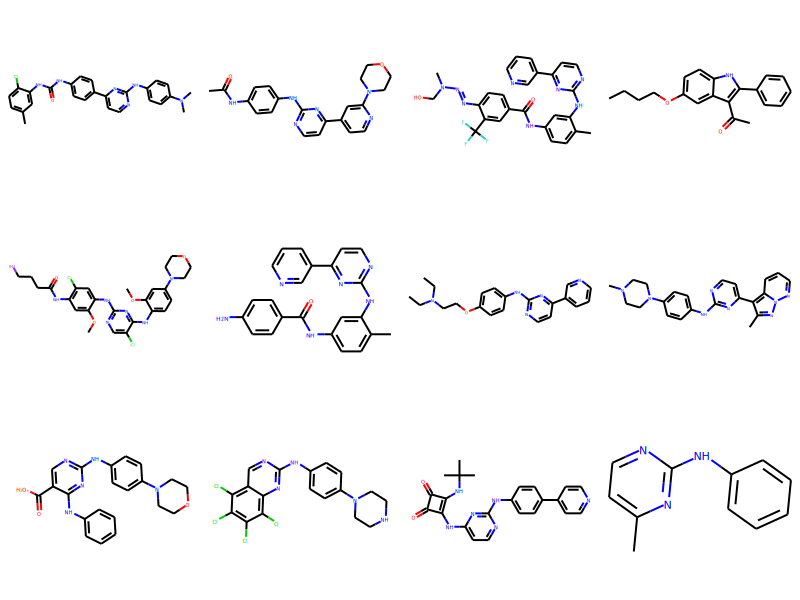

In [4]:
random.shuffle(kinase_outputs[0])
Draw.MolsToGridImage(kinase_outputs[0][:12], molsPerRow=4)

### GSK-3b(+) & JNK3(-)

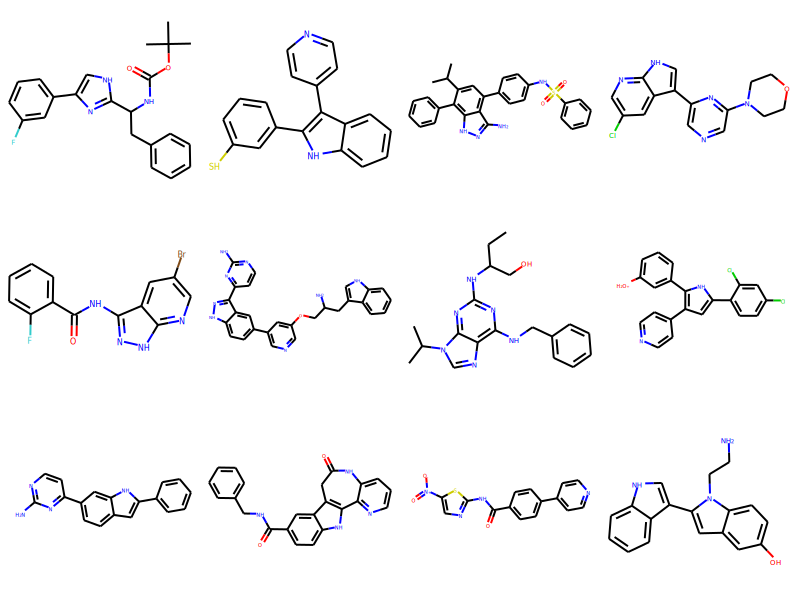

In [6]:
random.shuffle(kinase_outputs[1])
Draw.MolsToGridImage(kinase_outputs[1][:12], molsPerRow=4)

### GSK-3b(-) & JNK3(+)

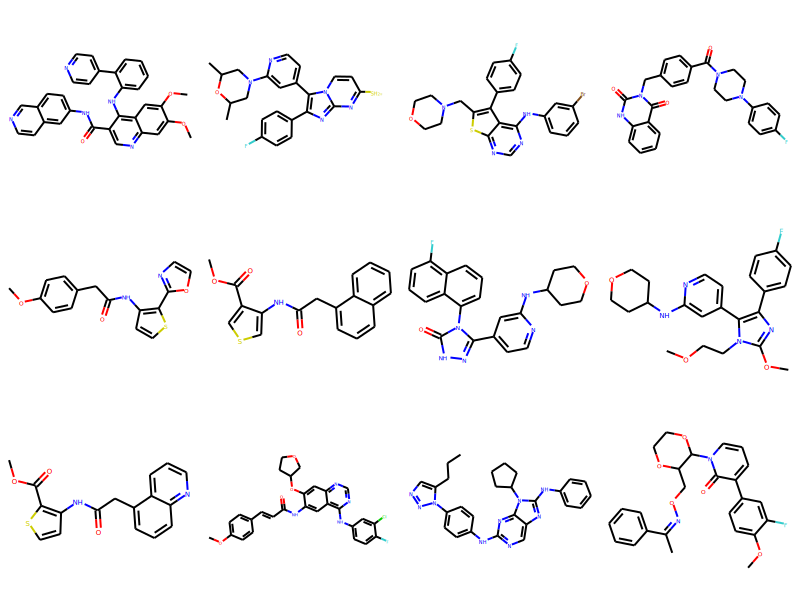

In [7]:
random.shuffle(kinase_outputs[2])
Draw.MolsToGridImage(kinase_outputs[2][:12], molsPerRow=4)